# Série temporais multivariadas com o *Facebook Prophet*

O *Facebook Prophet* é uma ferramenta de análise de séries temporais desenvolvida pelo *Facebook* com a finalidade de modelar séries temporais de forma fácil e sem a necessidade de aprofundamento na teoria que envolve esse tipo de dado, ou sjea, com poucos comandos e parâmetros é possível extrair vários gráficos, informações e previsões. Essa biblioteca funciona como uma caixa preta, isto é, os dados são inseridos dentro do modelo e o modelo *cospe* um resultado, entretanto como ele realiza essa tarefa é um mistério para o usuário.

Nesse novo projeto, primeiramente, usarei modelo padrão sem o uso de regressores e depois aplicarei os regressores ao modelo e vou comparar os resultados de ambos.

## Dados

Os dados foram obtidos [aqui](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data) e referem-se ao clima na na cidade de Delhi, Índia. A periodicidade diária e as variáveis são:

1) *meantemp* - temperatura média (variável alvo);

2) *humidity* - umidade;

3) *wind_speed* - velocidade do vento;

4) *meanpressure* - pressão média

## Importação das bibliotecas

In [303]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error
from scipy.stats import shapiro, jarque_bera
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot

## Importação das bases de dados

In [ ]:
treino = pd.read_csv('DailyDelhiClimateTrain.csv')
treino

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


Base de teste.

In [ ]:
teste = pd.read_csv('DailyDelhiClimateTest.csv')
teste

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


Para não ter o problema com indexação mais a frente irei unir as bases de dados, para que as previsões do modelo tenham a mesma indexação da base de teste que irei separar.

In [ ]:
frames = [treino, teste]
serie = pd.concat(frames)
serie.reset_index(inplace=True)
serie = serie.drop('index', axis=1)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1571,2017-04-20,34.500000,27.500000,5.562500,998.625000
1572,2017-04-21,34.250000,39.375000,6.962500,999.875000
1573,2017-04-22,32.900000,40.900000,8.890000,1001.600000
1574,2017-04-23,32.875000,27.500000,9.962500,1002.125000


Por um exigência da biblioteca é necessário renomear todas as variáveis, sendo a variável de datas renomeada para *ds*, a nossa variável alvo é a temperatura e será renomeada para *y* e as demais (umidade - *humidity*, velocidade do vento - *wind_spped* e pressão média - *meanpressure*) regressoras e serão renomeadas para *add1*, *add2* e *add3*, respectivamente.

In [ ]:
serie = serie.rename(columns={'date':'ds', 'meantemp':'y','humidity':'add1','wind_speed':'add2','meanpressure':'add3'})

Base de dados renomeada.

In [200]:
serie.head()

,index,ds,y,add1,add2,add3
0,0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


Plotando a base de dados.

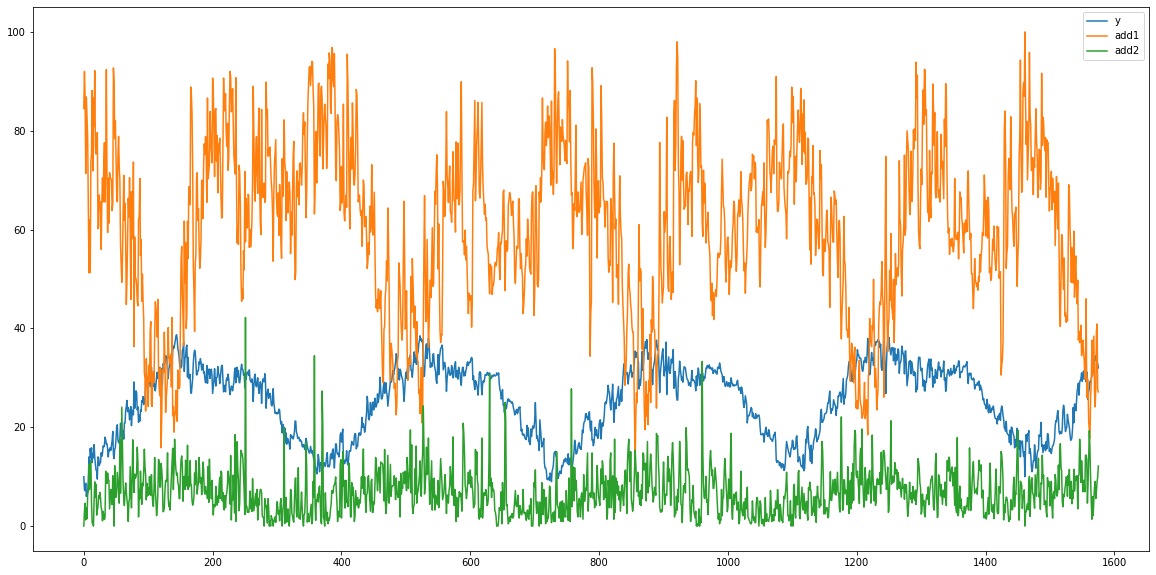

In [ ]:
serie[['y','add1','add2']].plot(figsize=(20,10));

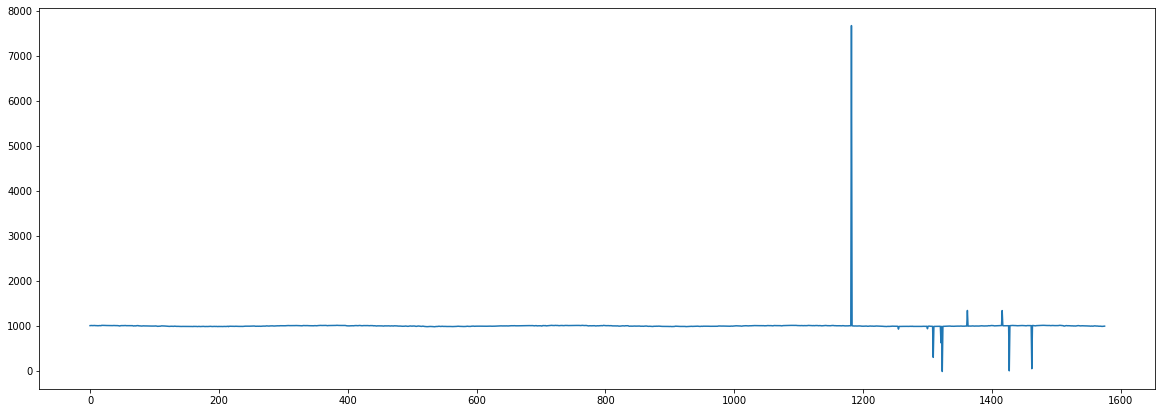

In [202]:
serie['add3'].plot(figsize=(20,7))

## Análise exploratória

Tabela estatística das séries de tempo.

In [203]:
serie.describe()

,index,y,add1,add2,add3
count,1576.000000,1576.000000,1576.000000,1576.000000,1576.000000
mean,681.746193,25.221918,60.445229,6.899262,1010.593178
std,442.630431,7.345014,16.979994,4.510725,175.242704
min,0.000000,6.000000,13.428571,0.000000,-3.041667
25%,279.750000,18.500000,49.750000,3.700000,1001.875000
50%,673.500000,27.166667,62.440476,6.363571,1009.055556
75%,1067.250000,31.142857,72.125000,9.262500,1015.200000
max,1461.000000,38.714286,100.000000,42.220000,7679.333333


Correlação entre as variáveis.

In [199]:
serie.corr()

,index,y,add1,add2,add3
index,1.000000,0.172282,-0.022039,-0.051361,0.017000
y,0.172282,1.000000,-0.574849,0.288088,-0.034681
add1,-0.022039,-0.574849,1.000000,-0.373602,-0.001672
add2,-0.051361,0.288088,-0.373602,1.000000,-0.016949
add3,0.017000,-0.034681,-0.001672,-0.016949,1.000000


Histograma das variáveis.

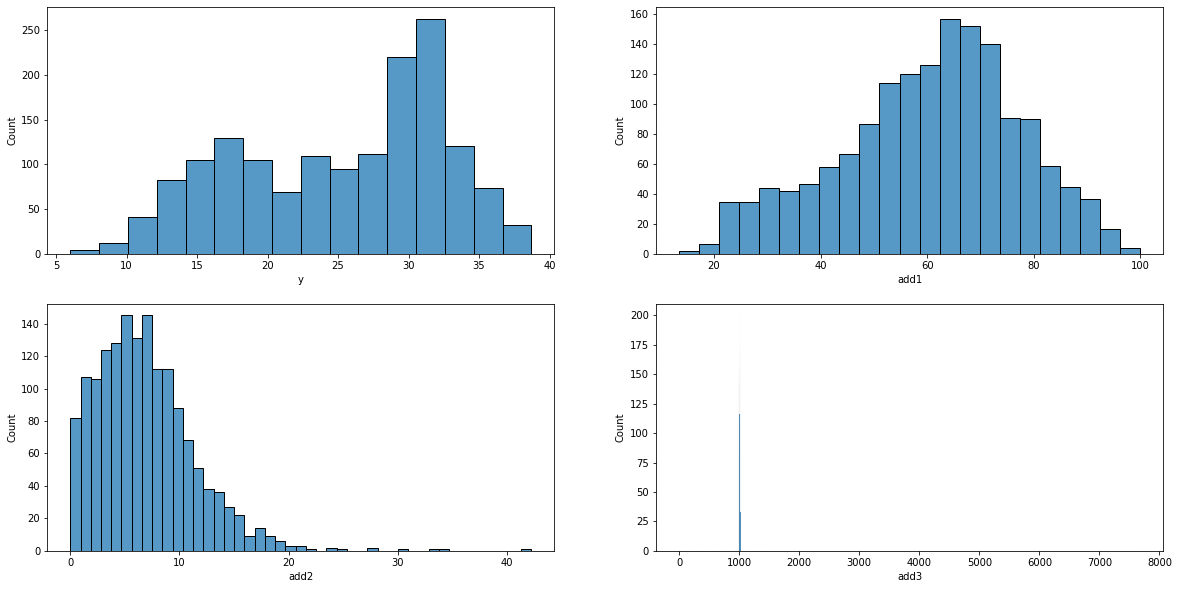

In [198]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
sns.histplot(serie['y'], ax=ax[0][0])
sns.histplot(serie['add1'], ax=ax[0][1])
sns.histplot(serie['add2'], ax=ax[1][0])
sns.histplot(serie['add3'], ax=ax[1][1])

*Boxplot* das variáveis.

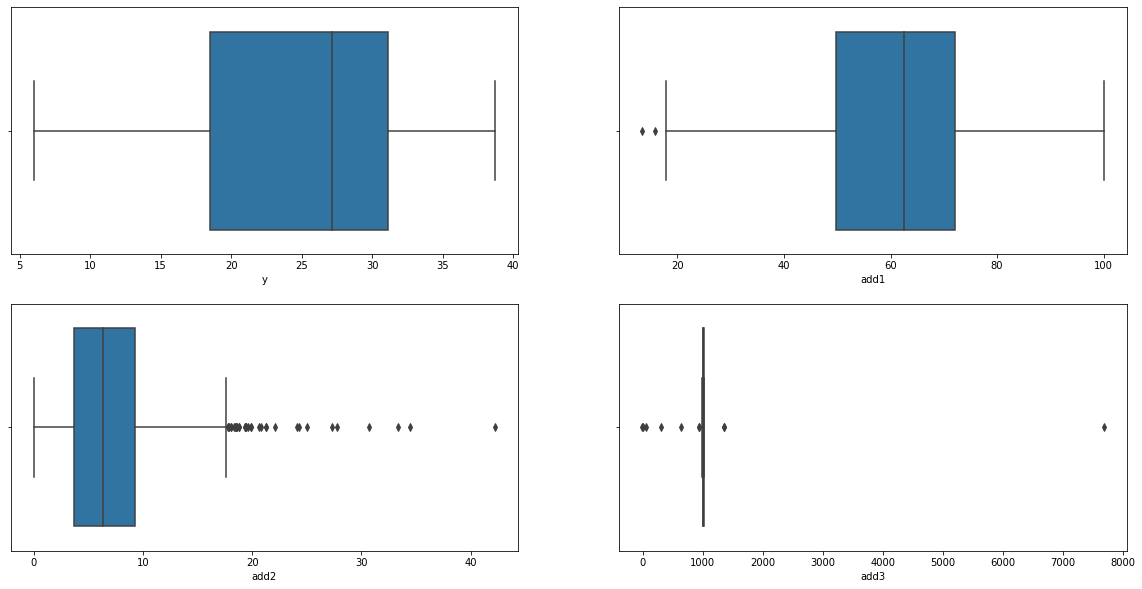

In [207]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
sns.boxplot(x = 'y', data = serie, ax=ax[0][0])
sns.boxplot(x = 'add1', data = serie, ax=ax[0][1])
sns.boxplot(x = 'add2', data = serie, ax=ax[1][0])
sns.boxplot(x = 'add3', data = serie, ax=ax[1][1]);

## Separando dados de treino e teste

A parte de treino será usada para a modelagem e depois as previsões serão geradas por ele, em seguida essas previsões serão comparadas com os valores reais.

Aqui separarei os dados arbritariamente, por critério meu apenas e escolhendo para base de teste as últimas 114 observações.

In [ ]:
treino = serie[0:1461]
teste = serie[1462:1576]

Dimensão da base de treino.

In [ ]:
treino.shape

(1461, 6)

Dimensão da base de teste.

In [ ]:
teste.shape

(114, 6)

## Modelagem sem os regressores

Aqui irei realizar uma modelagem padrão dos dados, sem alterar os parâmetros e analisar o desempenho do modelo.

In [209]:
#instanciando e treinando o modelo
modelo1=Prophet()
modelo1.fit(treino)

#gerando as previsões do modelo
futuro=modelo1.make_future_dataframe(periods=115, freq='D')
previsoes=modelo1.predict(futuro)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Visualizando os dados reais e as previsões.

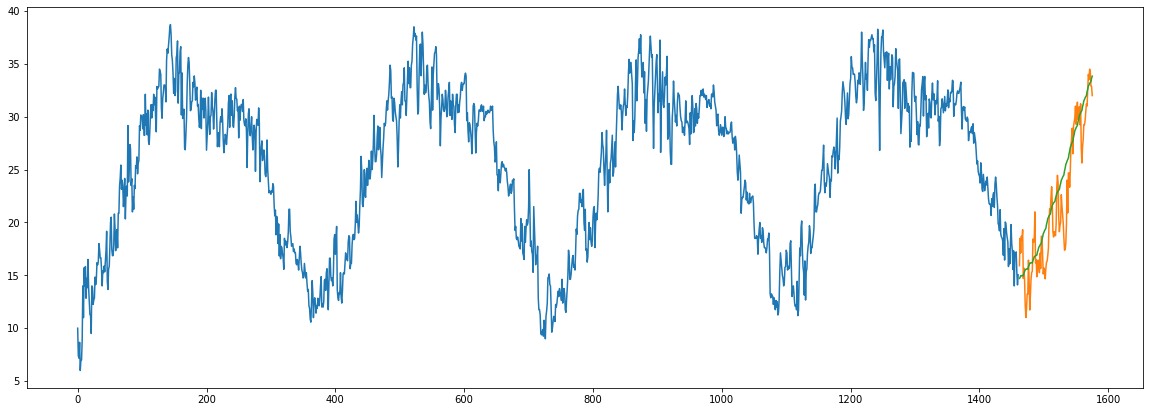

In [210]:
treino['y'].plot(figsize=(20,7))
teste['y'].plot()
previsoes['yhat'][1462:1576].plot();
#teste['y'].plot();

### Métricas de desempenho do modelo 1

Para o $R^2$ o valor, preferencialmente, deve ser o maior possível; entretanto para as demais métricas o valor deve ser o mais próximo possível de zero.

In [231]:
print("R2 :", round(r2_score(teste['y'],previsoes['yhat'][1462:1576])*100,3),'%')
print("Erro médio absoluto :", round(mean_absolute_error(teste['y'],previsoes['yhat'][1462:1576]),3))
print("Erro médio quadrado :", round(mean_squared_error(teste['y'],previsoes['yhat'][1462:1576])**.5,3))
print("Erro médio logarítmico quadrado :", round(mean_squared_log_error(teste['y'],previsoes['yhat'][1462:1576]),3))
print("Erro mediano absoluto :", round(median_absolute_error(teste['y'],previsoes['yhat'][1462:1576]),3))

R2 : 80.457 %
Erro médio absoluto : 2.261
Erro médio quadrado : 2.799
Erro médio logarítmico quadrado : 0.019
Erro mediano absoluto : 1.927


### Análise dos resíduos do modelo 1

Uma análise importante é a dos resíduos do modelo, que são a diferença entre o predito e o estimado. É interessante que os nossos modelos tenham um comportamento normal, ou seja, média próximo de zero e a variância sendo constante.

Irei aplicar alguns testes estatísticos nos erros de treino e teste.

Abaixo vemos os resíduos para os dados de treino.

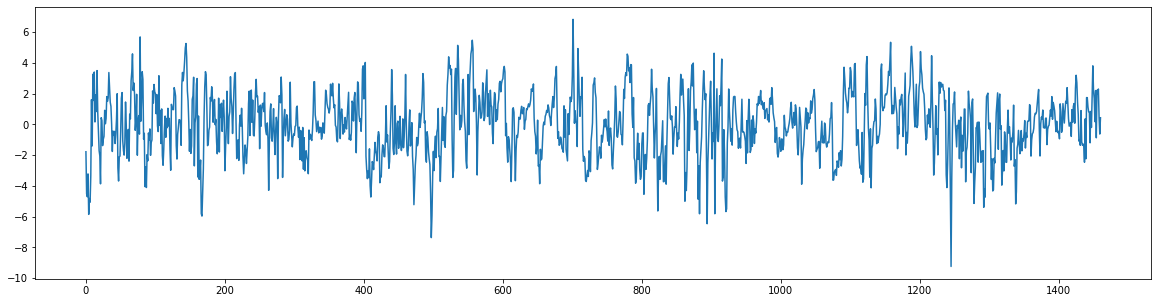

In [218]:
(treino['y'] - previsoes['yhat'][0:1462]).plot(figsize=(20,5));

Resíduos dos dados de teste.

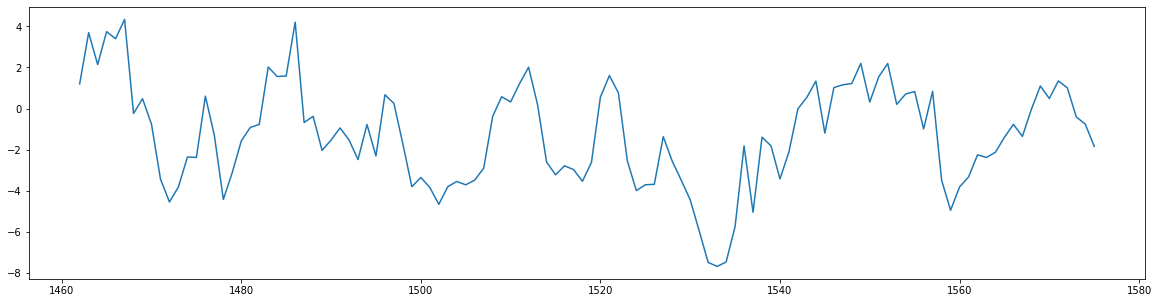

In [220]:
(teste['y'] - previsoes['yhat'][1462:1576]).plot(figsize=(20,5));

Histograma dos resíduos: observa-se que o histograma dos dados de treino possuem um comportamento normal, diferente do de teste.

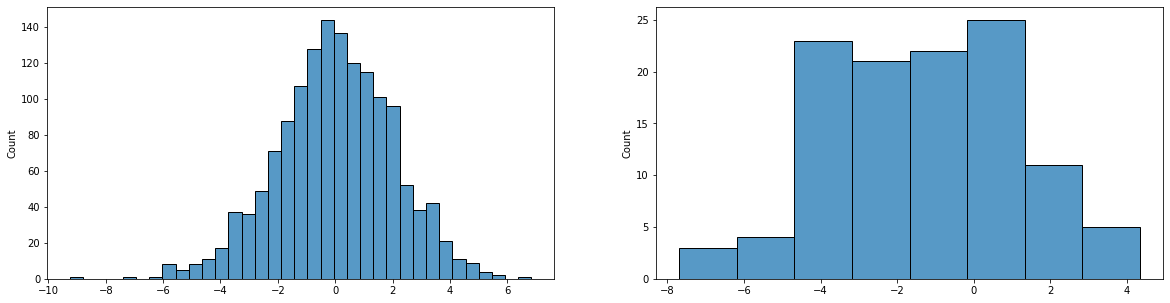

In [233]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.histplot((treino['y'] - previsoes['yhat'][0:1462]), ax=ax[0])
sns.histplot(teste['y'] - previsoes['yhat'][1462:1576], ax=ax[1]);

In [255]:
resid_treino = treino['y'] - previsoes['yhat'][0:1462]
resid_teste = teste['y'] - previsoes['yhat'][1462:1576]

**Teste de normalidade para os resíduos**

Para os resíduos de treino.

In [257]:
print('Estatística do teste Shapiro-Wilk:',round(shapiro(resid_treino)[0],3))
print('p-valor do teste Shapiro-Wilk:',round(shapiro(resid_treino)[1],3))
print(''*254)
print('Estatística do teste Jarque-Bera:',round(jarque_bera(resid_treino)[0],3))
print('p-valor do teste Jarque-Bera:',round(jarque_bera(resid_treino)[1],3))

Estatística do teste Shapiro-Wilk: nan
p-valor do teste Shapiro-Wilk: 1.0

Estatística do teste Jarque-Bera: nan
p-valor do teste Jarque-Bera: nan


Para os resíduos de teste: o *p-valor* dos teste apresentaram valor maiores que 5% (nível de significância padrão), então podemos aceitar a hipótese nula de normalidade desses dois testes.

In [254]:
print('Estatística do teste Shapiro-Wilk:',round(shapiro(resid_teste)[0],3))
print('p-valor do teste Shapiro-Wilk:',round(shapiro(resid_teste)[1],3))
print(''*254)
print('Estatística do teste Jarque-Bera:',round(jarque_bera(resid_teste)[0],3))
print('p-valor do teste Jarque-Bera:',round(jarque_bera(resid_teste)[1],3))

Estatística do teste Shapiro-Wilk: 0.986
p-valor do teste Shapiro-Wilk: 0.306

Estatística do teste Jarque-Bera: 0.467
p-valor do teste Jarque-Bera: 0.792


**Teste de aucorrelação residual**

Para esse teste é ideal que o resultado esteja próximo do valor 2. O resultado do teste ficou bem próximo de zero, indicando a presença de autocorrelação serial positiva.

In [245]:
durbin_watson(teste['y'] - previsoes['yhat'][1462:1576])

0.3530816304681281

Componentes da série gerados pelo modelo 1.

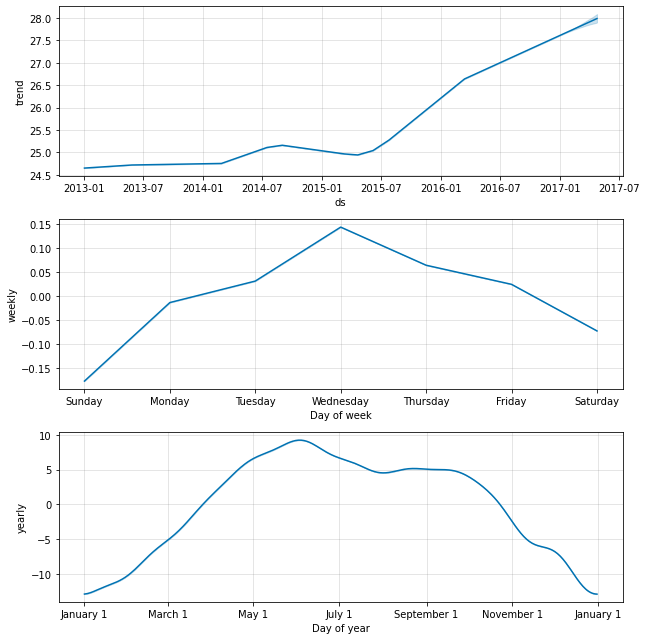

In [221]:
fig = modelo1.plot_components(previsoes);

### Validação cruzada do modelo 1

Em modelos tradicionais de *machine learning* a validação cruzada é quando separa-se os dados em um número de porções e aplica-se ao modelo partes diferentes de dados de treino e teste, e em seguida, tira-se uma média aritmética dos resultados.

Essa etapa também pode ser realizada em modelos de séries temporais, mas de forma diferente, onde o modelo é treinado com uma porção dos dados e em seguida gera previsões e compara-se com os valores reais; então realiza-se o treino, validação e avaliação aumentando com uma porção de dados maior.

Imagine o conjunto de dados: [1, 2, 3, 4, 5, 6, 7, 8]

A etapa seria:

-Treinamento com [1], gera a previsão e compara o resultado com [2].

-Treinamento com [1, 2], gera as previsão e compara o resultado com [3].

-Treinamento com [1, 2, 3], gera as previsão e compara o resultado com [4].

-Treinamento com [1, 2, 3, 4], gera as previsão e compara o resultado com [5].

-Treinamento com [1, 2, 3, 4, 5], gera as previsão e compara o resultado com [6].

Em trabalhos tradicionais com modelos de *machine learning* essa etapa serve para identificar a capacidade de generalização do modelo, ou seja, se ele tem um bom desempenho de previsão para todos os dados. Em séries temporais é para encontrar o modelo que erre menos ao longo do tempo.

In [312]:
modelo1_vc = cross_validation(modelo1, horizon='120 days')

INFO:fbprophet:Making 17 forecasts with cutoffs between 2014-01-16 00:00:00 and 2016-09-02 00:00:00


Abaixo o resultado da validação cruzada.

In [320]:
modelo1_vc

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-01-17,14.347577,12.280577,16.453825,12.000000,2014-01-16
1,2014-01-18,14.643176,12.571016,16.823711,12.500000,2014-01-16
2,2014-01-19,14.919958,12.821464,17.183931,14.500000,2014-01-16
3,2014-01-20,15.478086,13.407849,17.575148,14.625000,2014-01-16
4,2014-01-21,15.708015,13.540427,17.813377,13.571429,2014-01-16
...,...,...,...,...,...,...
2035,2016-12-27,14.082042,11.412739,16.501224,16.850000,2016-09-02
2036,2016-12-28,14.176942,11.440194,16.747131,17.217391,2016-09-02
2037,2016-12-29,14.067599,11.289066,16.687080,15.238095,2016-09-02
2038,2016-12-30,14.024186,11.574527,16.784111,14.095238,2016-09-02


Plotando os resultados vemos que o modelo aparenta ter um bom desempenho, visto que os resultados reais (em vermelho) encontram-se, em sua maioria, dentro do intervalo de confiança da série estimada.

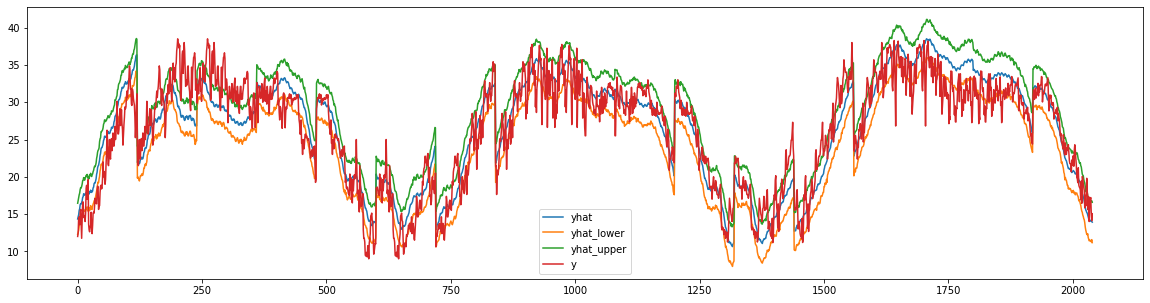

In [321]:
modelo1_vc[['yhat','yhat_lower','yhat_upper','y']].plot(figsize=(20,5));

Abaixo pode-se ver as métricas de avaliação para cada dia do horizonte de tempo que foi escolhi (arbitrariamente).

In [314]:
modelo1_pm = performance_metrics(modelo1_vc)
modelo1_pm

,horizon,mse,rmse,mae,mape,mdape,coverage
0,12 days,4.219493,2.054141,1.616136,0.071383,0.048812,0.779412
1,13 days,4.086441,2.021495,1.598339,0.070348,0.050809,0.784314
2,14 days,4.068890,2.017149,1.596641,0.070161,0.050396,0.784314
3,15 days,3.822494,1.955120,1.561220,0.068602,0.049497,0.803922
4,16 days,3.664390,1.914260,1.513545,0.067696,0.047516,0.808824
...,...,...,...,...,...,...,...
104,116 days,9.064541,3.010738,2.341355,0.099546,0.067242,0.612745
105,117 days,10.165518,3.188341,2.456343,0.104488,0.073816,0.598039
106,118 days,11.519139,3.393986,2.613755,0.110512,0.077791,0.578431
107,119 days,12.649117,3.556560,2.774303,0.117128,0.083264,0.539216


Gerando o desempenho das métricas ao longo do tempo de forma gráfica.

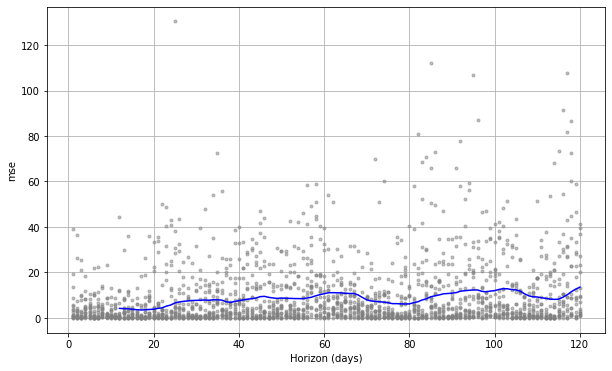

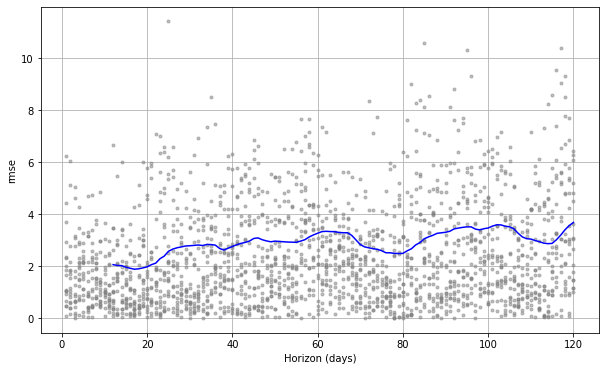

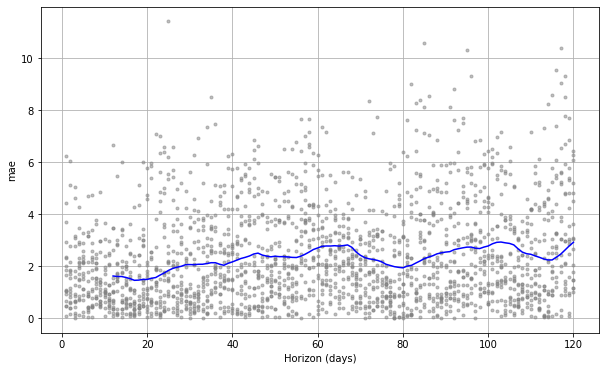

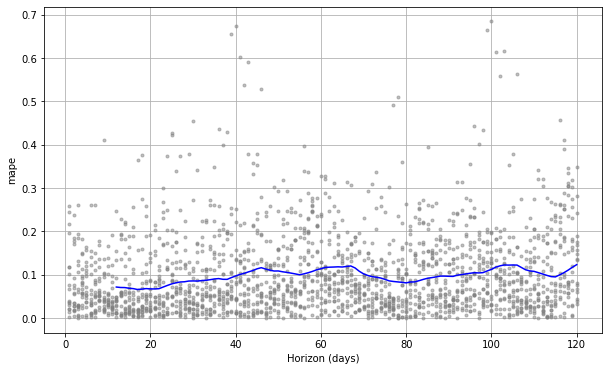

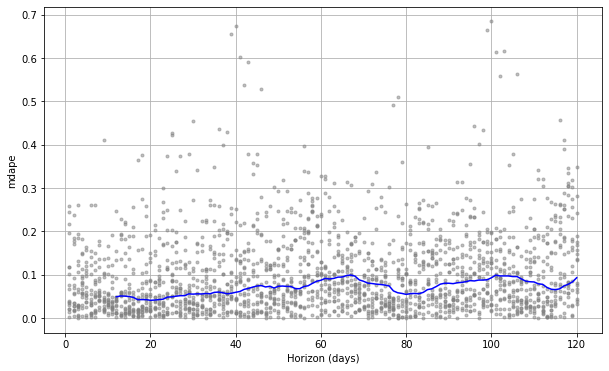

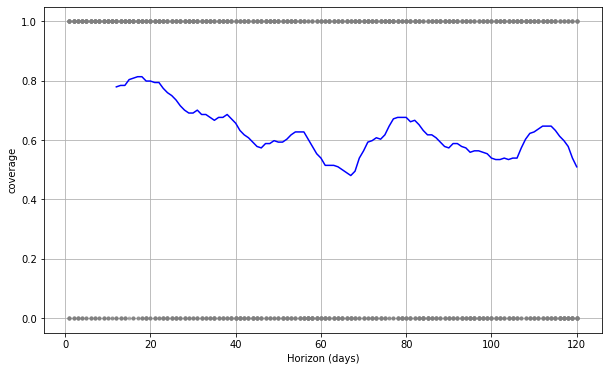

In [337]:
fig = plot_cross_validation_metric(modelo1_vc, metric='mse')
fig = plot_cross_validation_metric(modelo1_vc, metric='rmse')
fig = plot_cross_validation_metric(modelo1_vc, metric='mae')
fig = plot_cross_validation_metric(modelo1_vc, metric='mape')
fig = plot_cross_validation_metric(modelo1_vc, metric='mdape')
fig = plot_cross_validation_metric(modelo1_vc, metric='coverage')

## Modelagem com os regressores

Agora com os mesmos parâmetros do modelo anterior irei aplicar os regressores, que são as outras variáveis, em seguida, realizarei a avaliação do modelo e verificar se houve melhora em seu desempenho.

In [208]:
modelo2 = Prophet()

#Adicionando os regressores ao modelo prophet
#Utilizei várias combinações de regressores até achar um modelo que deu um resultado melhor
#que o modelo anterior, usando as variáveis de velocidade do vento e pressão média.

#modelo.add_regressor('add1')
modelo2.add_regressor('add2')
modelo2.add_regressor('add3')

Treinamento do modelo.

In [189]:
modelo2.fit(treino)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Agora, utlizarei apenas as variáveis regressoras, eliminando da base de teste a variável de temperatura.

In [190]:
forecast = modelo2.predict(teste.drop(columns='y'))
forecast.index=teste.index

Agora irei gerar o gráfico com os resultados.

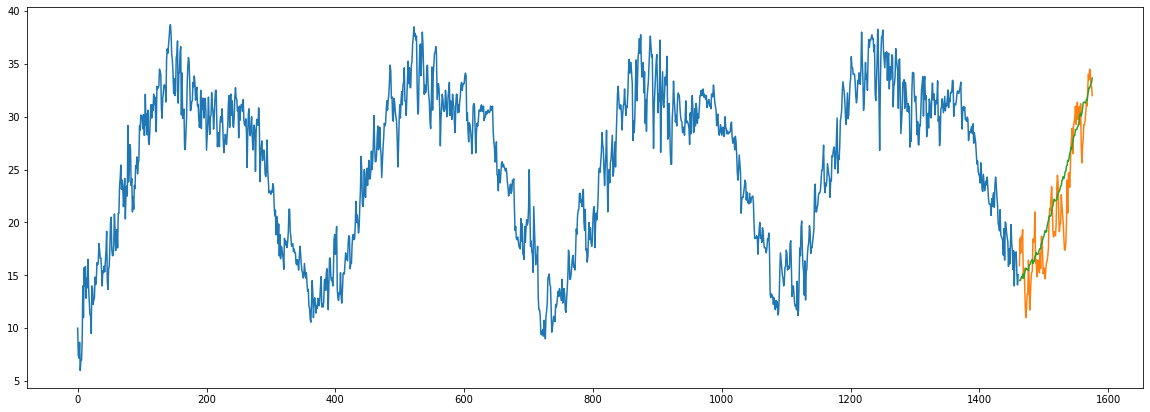

In [191]:
treino['y'].plot(figsize=(20,7))
teste['y'].plot()
forecast['yhat'].plot();

### Métricas de avaliação do modelo 2

Em comparação com o modelo anterior, as métricas obtiveram uma melhora ($R^2$ aumentou e as métricas de erro foram menores).

In [259]:
print("R2 :", round(r2_score(teste['y'],forecast['yhat'])*100,3),'%')
print("Erro médio absoluto :", round(mean_absolute_error(teste['y'],forecast['yhat']),3))
print("Erro médio quadrado :", round(mean_squared_error(teste['y'],forecast['yhat'])**.5,3))
print("Erro médio logarítmico quadrado :", round(mean_squared_log_error(teste['y'],forecast['yhat']),3))
print("Erro mediano absoluto :", round(median_absolute_error(teste['y'],forecast['yhat']),3))

R2 : 81.846 %
Erro médio absoluto : 2.221
Erro médio quadrado : 2.698
Erro médio logarítmico quadrado : 0.018
Erro mediano absoluto : 1.85


### Análise dos resíduos

Definindo uma variável para os resíduos.

In [264]:
resid_teste2=teste['y'] - forecast['yhat']

Aqui irei gerar 4 gráficos : o dos resíduos, o histograma dos respiduos, o gráfico de autocorrelação e o gráfico *QQplot*. Não é possível inferir visualmente nada sobre os dados, apenas que há indícios de autocorrelação neles, conforme gráfico 3.

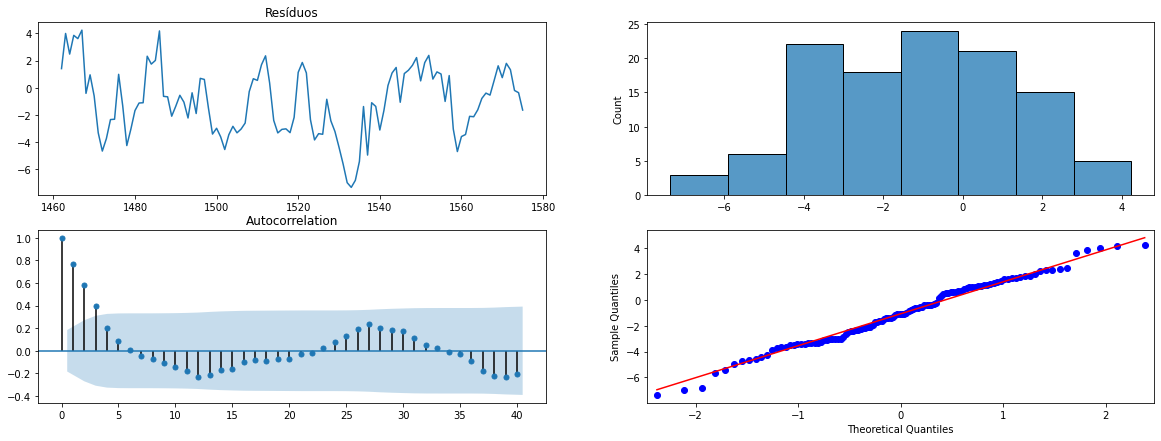

In [270]:
fig, ax = plt.subplots(2,2,figsize=(20,7))
resid_teste2.plot(title="Resíduos", ax=ax[0][0])
sns.histplot(resid_teste2,ax=ax[0][1])
plot_acf(resid_teste2,lags=40, ax=ax[1][0])
qqplot(resid_teste2,line='s', ax=ax[1][1]);

**Teste de normalidade dos resíduos**

Os teste de normalidade também mostraram que os dados possuem um comportamento normal, pois o *p-valor* ficou acima de 5% do nível de significância.

In [276]:
test1 = shapiro(resid_teste2)
print('Estatística Shapiro-Wilk :', round(test1[0],3))
print('P-valor :', round(test1[1],3))
print(' '*254)
test2 = jarque_bera(resid_teste2)
print('Estatística Jarque-Bera :', round(test2[0],3))
print('P-valor :', round(test2[1],3))

Estatística Shapiro-Wilk : 0.986
P-valor : 0.287
                                                                                                                                                                                                                                                              
Estatística Jarque-Bera : 0.932
P-valor : 0.628


**Teste de autocorrelação dos resíduos**

O teste de autocorrelação foi um pouco maior, mas mesmo assim indica a presença de autocorrelação seria positiva nos resíduos.

In [277]:
durbin_watson(resid_teste2)

0.39243506237970227

Componentes do modelo 2.

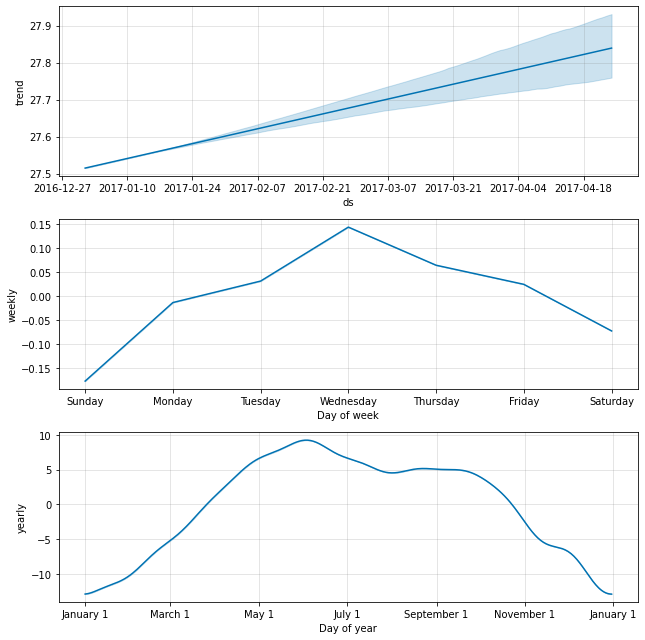

In [273]:
fig = modelo2.plot_components(forecast);

### Validação cruzada do modelo 2

Será realizado o mesmo procedimento que foi feito no modelo 1.

In [331]:
modelo2_vc = cross_validation(modelo2, horizon='120 days')

INFO:fbprophet:Making 17 forecasts with cutoffs between 2014-01-16 00:00:00 and 2016-09-02 00:00:00


Previsões, intervalo de confiança e valores reais.

In [332]:
modelo2_vc

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-01-17,14.347577,12.165991,16.554676,12.000000,2014-01-16
1,2014-01-18,14.643176,12.532896,16.731249,12.500000,2014-01-16
2,2014-01-19,14.919958,12.769731,17.057729,14.500000,2014-01-16
3,2014-01-20,15.478086,13.226390,17.603368,14.625000,2014-01-16
4,2014-01-21,15.708015,13.571518,17.924331,13.571429,2014-01-16
...,...,...,...,...,...,...
2035,2016-12-27,14.082042,11.480393,16.775424,16.850000,2016-09-02
2036,2016-12-28,14.176942,11.494730,16.856756,17.217391,2016-09-02
2037,2016-12-29,14.067599,11.442060,16.619719,15.238095,2016-09-02
2038,2016-12-30,14.024186,11.270715,16.753297,14.095238,2016-09-02


Gráfico com os valores.

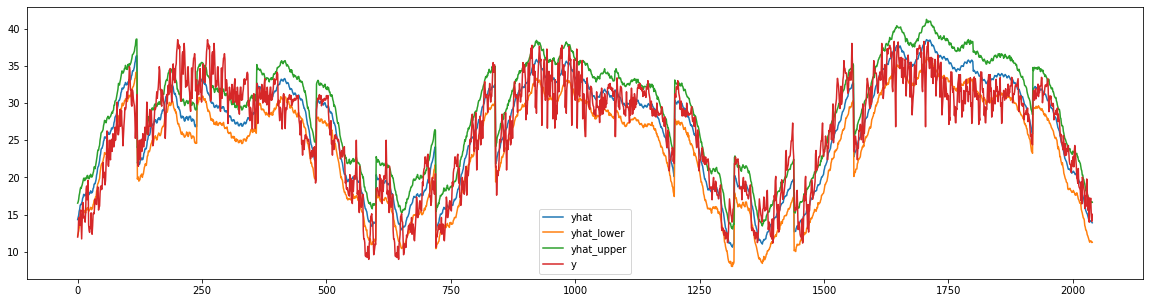

In [333]:
modelo2_vc[['yhat','yhat_lower','yhat_upper','y']].plot(figsize=(20,5));

Métricas ao longo do tempo.

In [334]:
modelo2_pm = performance_metrics(modelo2_vc)
modelo2_pm

,horizon,mse,rmse,mae,mape,mdape,coverage
0,12 days,4.219493,2.054141,1.616136,0.071383,0.048812,0.769608
1,13 days,4.086441,2.021495,1.598339,0.070348,0.050809,0.774510
2,14 days,4.068890,2.017149,1.596641,0.070161,0.050396,0.774510
3,15 days,3.822494,1.955120,1.561220,0.068602,0.049497,0.794118
4,16 days,3.664390,1.914260,1.513545,0.067696,0.047516,0.799020
...,...,...,...,...,...,...,...
104,116 days,9.064541,3.010738,2.341355,0.099546,0.067242,0.598039
105,117 days,10.165518,3.188341,2.456343,0.104488,0.073816,0.583333
106,118 days,11.519139,3.393986,2.613755,0.110512,0.077791,0.563725
107,119 days,12.649117,3.556560,2.774303,0.117128,0.083264,0.529412


Gráfico de das métricas.

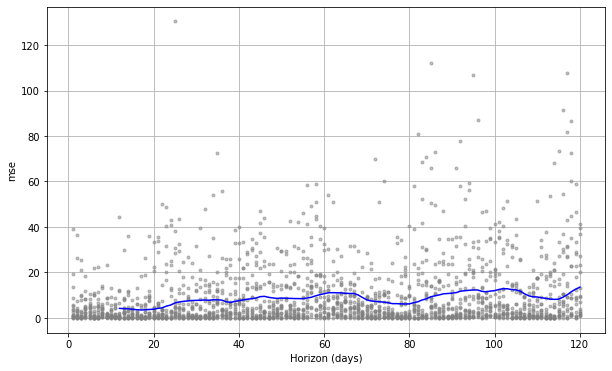

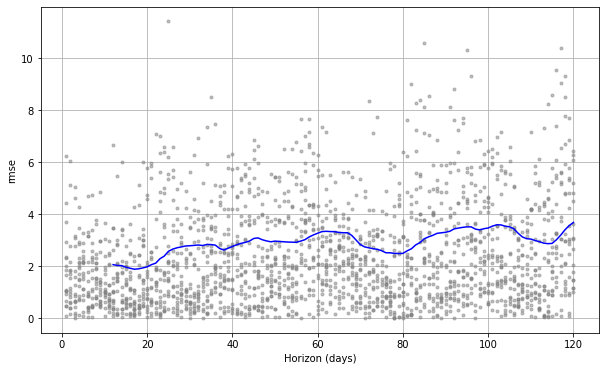

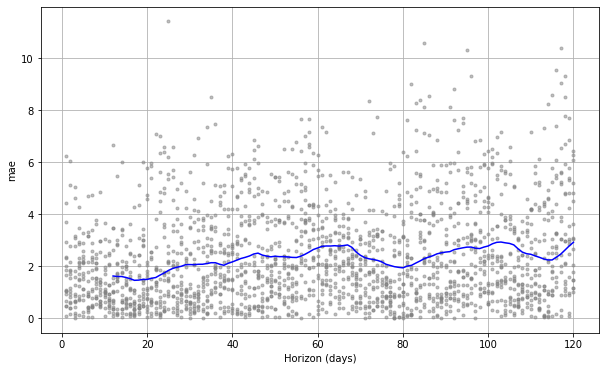

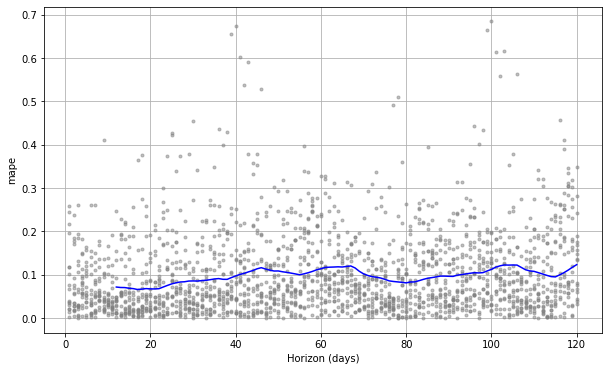

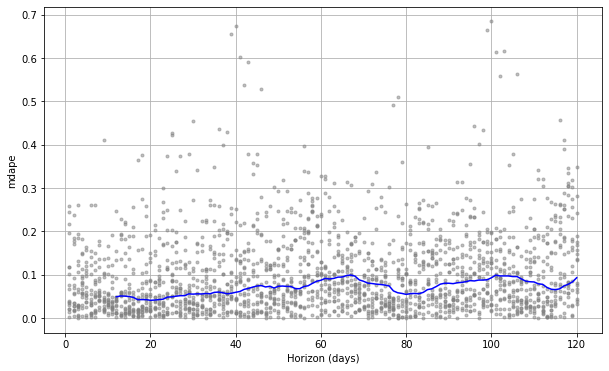

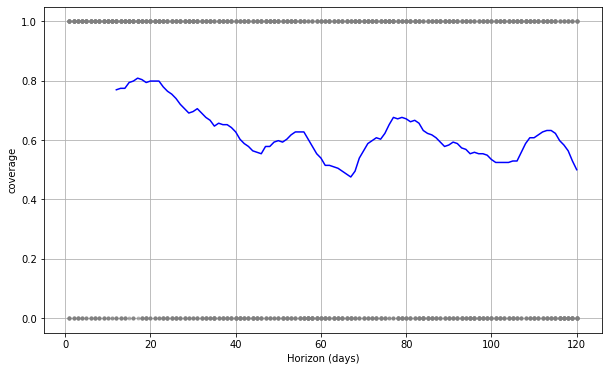

In [336]:
fig = plot_cross_validation_metric(modelo2_vc, metric='mse')
fig = plot_cross_validation_metric(modelo2_vc, metric='rmse')
fig = plot_cross_validation_metric(modelo2_vc, metric='mae')
fig = plot_cross_validation_metric(modelo2_vc, metric='mape')
fig = plot_cross_validation_metric(modelo2_vc, metric='mdape')
fig = plot_cross_validation_metric(modelo2_vc, metric='coverage')

## Conclusão

Nesse novo projeto apliquei regressores ao modelo *Prophet* padrão e obtive melhora no desempenho das métricas de avaliação do segundo modelo em relação ao primeiro. Vê-se que a biblioteca *Facebook Prophet* permite a inserção de outras variáveis no modelo, enriquecendo a modelagem e a previsão.